# Attacking Midfielders & Wingers — PCA & Clustering Analysis

**Goal:** Prepare features and run PCA + GMM clustering for the **Attacking Midfielders & Wingers** cohort (Wing Backs/Full Backs + Holding Midfielders + Central Midfielders).


## 1. Imports & Configuration


In [29]:
import os
import json
from pathlib import Path
import warnings
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import mstats
from statsbombpy import sb

warnings.filterwarnings('ignore')

# Load environment variables
load_dotenv()

# Set credentials if available
username = os.getenv('SB_USERNAME')
password = os.getenv('SB_PASSWORD')
creds = {'user': username, 'passwd': password} if username and password else None

if creds:
    print("✓ Credentials loaded successfully")
else:
    print("⚠ No credentials found - using open data access only")

# Configuration
RANDOM_SEED = 42
MIN_MINUTES = 500
MISSING_THRESHOLD = 0.30  # Drop features with ≥30% missing
COVERAGE_360_THRESHOLD = 0.70  # Keep 360 metrics if ≥70% have data
WINSORIZE_LIMITS = (0.01, 0.99)  # 1st and 99th percentiles
COLLINEARITY_THRESHOLD = 0.90  # Drop one feature if |r| ≥ 0.90
NORMALIZATION_MODE = "zscore"  # Options: "zscore" or "l2"
COMPETITION_ID = 73  # Liga MX

np.random.seed(RANDOM_SEED)

# Plotting defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

print("✓ Imports complete")
print(f"Config: MIN_MINUTES={MIN_MINUTES}, NORMALIZATION_MODE={NORMALIZATION_MODE}, COMPETITION_ID={COMPETITION_ID}")


✓ Credentials loaded successfully
✓ Imports complete
Config: MIN_MINUTES=500, NORMALIZATION_MODE=zscore, COMPETITION_ID=73


## 2. Paths & Logger Setup


In [30]:
# Artifact directory
ARTIFACT_BASE = Path("../data/processed/attacking_midfielders_wingers_artifacts")
ARTIFACT_BASE.mkdir(parents=True, exist_ok=True)

def get_season_artifact_dir(season_id: int, season_name: str) -> Path:
    """Create and return season-specific artifact directory."""
    season_dir = ARTIFACT_BASE / str(season_id)
    season_dir.mkdir(parents=True, exist_ok=True)
    return season_dir

def log_message(msg: str, level: str = "INFO"):
    """Simple logger."""
    print(f"[{level}] {msg}")

print(f"✓ Artifact base directory: {ARTIFACT_BASE.absolute()}")


✓ Artifact base directory: c:\Users\carls\OneDrive\Dokumente\Uni\05 Semester\Marketing y Estrategia de Deportes\Projekt\Repo\ISAC2025\notebooks\..\data\processed\attacking_midfielders_wingers_artifacts


## 3. Position Definitions


In [31]:
# Positions in scope
ATTACKING_MID_WINGER_POSITIONS = [
    # Wide Midfielders
    "Right Midfielder",
    "Left Midfielder",
    
    # Wingers
    "Right Wing",
    "Left Wing",
    
    # Attacking Midfielders
    "Right Attacking Midfielder",
    "Centre Attacking Midfielder",
    "Left Attacking Midfielder"
]

print("✓ Attacking Midfielder & Winger positions defined:")
for pos in ATTACKING_MID_WINGER_POSITIONS:
    print(f"  - {pos}")

✓ Attacking Midfielder & Winger positions defined:
  - Right Midfielder
  - Left Midfielder
  - Right Wing
  - Left Wing
  - Right Attacking Midfielder
  - Centre Attacking Midfielder
  - Left Attacking Midfielder


## 4. Feature Definitions


In [32]:
# Combined feature list for Attacking Midfielders & Wingers
BASE_FEATURES = [
    # --- Offensive Production ---
    'player_season_goals_90', 'player_season_npg_90', 'player_season_np_xg_90',
    'player_season_np_xg_per_shot', 'player_season_conversion_ratio',
    'player_season_shot_on_target_ratio', 'player_season_shot_touch_ratio',
    'player_season_touches_inside_box_90', 'player_season_over_under_performance_90',
    'player_season_npxgxa_90',
    
    # --- Chance Creation & Playmaking ---
    'player_season_assists_90', 'player_season_op_assists_90',
    'player_season_key_passes_90', 'player_season_op_key_passes_90',
    'player_season_sp_assists_90', 'player_season_sp_key_passes_90',
    'player_season_through_balls_90', 'player_season_xa_90',
    'player_season_op_xa_90', 'player_season_sp_xa_90',
    'player_season_xgchain_90', 'player_season_xgbuildup_90',
    'player_season_shots_key_passes_90',
    
    # --- Ball Progression & Involvement ---
    'player_season_carries_90', 'player_season_carry_length', 'player_season_carry_ratio',
    'player_season_deep_completions_90', 'player_season_deep_progressions_90',
    'player_season_op_passes_90', 'player_season_passes_into_box_90',
    'player_season_op_passes_into_box_90', 'player_season_lbp_90',
    'player_season_lbp_completed_90', 'player_season_lbp_ratio',
    'player_season_f3_lbp_90', 'player_season_f3_lbp_completed_90',
    'player_season_f3_lbp_ratio', 'player_season_obv_dribble_carry_90',
    'player_season_obv_pass_90', 'player_season_obv_shot_90',
    'player_season_obv_defensive_action_90', 'player_season_positive_outcome_90',
    'player_season_positive_outcome_score',
    
    # --- Width & Crossing ---
    'player_season_crosses_90', 'player_season_crossing_ratio',
    'player_season_box_cross_ratio', 'player_season_average_f3_space_received_in',
    'player_season_f3_ball_receipts_in_space_5_ratio',
    'player_season_f3_ball_receipts_in_space_10_ratio',
    'player_season_f3_lbp_received_90', 'player_season_f3_obv_lbp_90',
    
    # --- Passing Style & Directionality ---
    'player_season_passing_ratio', 'player_season_forward_pass_proportion',
    'player_season_backward_pass_proportion', 'player_season_sideways_pass_proportion',
    'player_season_pass_into_danger_ratio', 'player_season_pass_into_pressure_ratio',
    'player_season_p_pass_length', 'player_season_s_pass_length',
    'player_season_pass_length_ratio', 'player_season_op_f3_forward_pass_proportion',
    'player_season_op_f3_backward_pass_proportion', 'player_season_op_f3_sideways_pass_proportion',
    
    # --- Ball Retention & Risk ---
    'player_season_total_dribbles_90', 'player_season_dribbles_90',
    'player_season_failed_dribbles_90', 'player_season_dribble_ratio',
    'player_season_turnovers_90', 'player_season_dispossessions_90',
    'player_season_errors_90',
    
    # --- Defensive & Pressing Workrate ---
    'player_season_pressures_90', 'player_season_fhalf_pressures_90',
    'player_season_fhalf_pressures_ratio', 'player_season_counterpressures_90',
    'player_season_fhalf_counterpressures_ratio', 'player_season_defensive_action_90',
    'player_season_padj_tackles_and_interceptions_90', 'player_season_ball_recoveries_90',
    'player_season_fhalf_ball_recoveries_90',
]

print(f"✓ Total features defined: {len(BASE_FEATURES)}")

✓ Total features defined: 79


In [33]:
# Define all available Liga MX seasons
SEASON_INFO = [
    {"id": 108, "name": "2021/2022", "year": "21/22"},
    {"id": 235, "name": "2022/2023", "year": "22/23"},
    {"id": 281, "name": "2023/2024", "year": "23/24"},
    {"id": 317, "name": "2024/2025", "year": "24/25"}
]

log_message(f"Found {len(SEASON_INFO)} seasons")
for s in SEASON_INFO:
    print(f"  - {s['id']}: {s['name']} ({s['year']})")


[INFO] Found 4 seasons
  - 108: 2021/2022 (21/22)
  - 235: 2022/2023 (22/23)
  - 281: 2023/2024 (23/24)
  - 317: 2024/2025 (24/25)


In [34]:
# Fetch data from all seasons
log_message("\n" + "="*80)
log_message("FETCHING DATA")
log_message("="*80)

all_season_stats = []

for season in SEASON_INFO:
    season_id = season['id']
    season_name = season['name']
    
    log_message(f"Fetching season {season_name} (ID: {season_id})...")
    season_stats = sb.player_season_stats(competition_id=COMPETITION_ID, season_id=season_id, creds=creds)
    
    # Add season information
    season_stats['season_id'] = season_id
    season_stats['season_name'] = season_name
    
    # Create unique player identifier combining player_id and season_id
    season_stats['player_season_id'] = season_stats['player_id'].astype(str) + '_' + season_stats['season_id'].astype(str)
    
    all_season_stats.append(season_stats)
    log_message(f"  - Found {len(season_stats)} player records")

# Combine all seasons
combined_season_stats = pd.concat(all_season_stats, ignore_index=True)
log_message(f"\n✓ Total combined records: {len(combined_season_stats)}")
log_message(f"✓ Columns: {len(combined_season_stats.columns)}")


[INFO] 
[INFO] FETCHING DATA
[INFO] ================================================================================
[INFO] Fetching season 2021/2022 (ID: 108)...


[INFO]   - Found 603 player records
[INFO] Fetching season 2022/2023 (ID: 235)...
[INFO]   - Found 591 player records
[INFO] Fetching season 2023/2024 (ID: 281)...
[INFO]   - Found 623 player records
[INFO] Fetching season 2024/2025 (ID: 317)...
[INFO]   - Found 636 player records
[INFO] 
✓ Total combined records: 2453
[INFO] ✓ Columns: 225


In [35]:
# Filter by positions
log_message("\n" + "="*80)
log_message("POSITION FILTERING")
log_message("="*80)

# Create position filter
position_filter = (
    combined_season_stats['primary_position'].isin(ATTACKING_MID_WINGER_POSITIONS) | 
    combined_season_stats['secondary_position'].isin(ATTACKING_MID_WINGER_POSITIONS)
)

attacking_mid_winger_stats = combined_season_stats[position_filter].copy()
log_message(f"Players matching positions: {len(attacking_mid_winger_stats)}")

# Filter by minutes
combined_filtered = attacking_mid_winger_stats[attacking_mid_winger_stats['player_season_minutes'] >= MIN_MINUTES].copy()
log_message(f"Players with {MIN_MINUTES}+ minutes: {len(combined_filtered)}")

# Show position distribution
log_message(f"\n✓ Position distribution (primary):")
primary_positions = combined_filtered['primary_position'].value_counts()
for pos, count in primary_positions.items():
    print(f"  - {pos}: {count}")

log_message(f"\n✓ Players per season:")
season_counts = combined_filtered['season_name'].value_counts().sort_index()
for season, count in season_counts.items():
    print(f"  - {season}: {count}")

log_message(f"\n✓ Total player-seasons for analysis: {len(combined_filtered)}")


[INFO] 
[INFO] POSITION FILTERING
[INFO] ================================================================================
[INFO] Players matching positions: 750
[INFO] Players with 500+ minutes: 474
[INFO] 
✓ Position distribution (primary):
  - Right Wing: 80
  - Centre Attacking Midfielder: 79
  - Left Wing: 79
  - Left Midfielder: 57
  - Right Midfielder: 52
  - Centre Forward: 15
  - Left Back: 15
  - Right Back: 14
  - Left Wing Back: 14
  - Left Centre Midfielder: 12
  - Left Defensive Midfielder: 9
  - Left Centre Forward: 8
  - Right Centre Midfielder: 6
  - Right Centre Back: 6
  - Right Centre Forward: 6
  - Goalkeeper: 5
  - Right Defensive Midfielder: 5
  - Left Centre Back: 4
  - Right Wing Back: 4
  - Left Attacking Midfielder: 3
  - Right Attacking Midfielder: 1
[INFO] 
✓ Players per season:
  - 2021/2022: 120
  - 2022/2023: 116
  - 2023/2024: 125
  - 2024/2025: 113
[INFO] 
✓ Total player-seasons for analysis: 474


## 5. Feature Extraction & Preprocessing


In [36]:
# Extract features from combined dataset
log_message("\n" + "="*80)
log_message("FEATURE EXTRACTION & PREPROCESSING")
log_message("="*80)

# Check which features are available in the combined dataset
available_features = [f for f in BASE_FEATURES if f in combined_filtered.columns]
missing_features = [f for f in BASE_FEATURES if f not in combined_filtered.columns]

log_message(f"Available features: {len(available_features)}")
log_message(f"Missing features: {len(missing_features)}")
if missing_features:
    log_message("Missing features:", "WARNING")
    for feat in missing_features[:10]:  # Show first 10
        print(f"  - {feat}")

attacking_mid_winger_features = combined_filtered[available_features].copy()

# 1. Drop high-NaN columns
nan_threshold = 0.4
valid_cols = attacking_mid_winger_features.columns[attacking_mid_winger_features.isna().mean() <= nan_threshold]
attacking_mid_winger_features = attacking_mid_winger_features[valid_cols]
log_message(f"\n1. Features after NaN filtering (>{nan_threshold:.0%} threshold): {len(valid_cols)}")

# 2. Impute remaining NaN with median
attacking_mid_winger_features = attacking_mid_winger_features.apply(lambda s: s.fillna(s.median()), axis=0)
log_message(f"2. Remaining NaN values after imputation: {attacking_mid_winger_features.isna().sum().sum()}")

# 3. Drop zero-variance columns
zero_var = attacking_mid_winger_features.std() == 0
attacking_mid_winger_features = attacking_mid_winger_features.loc[:, ~zero_var]
log_message(f"3. Features after zero-variance filtering: {attacking_mid_winger_features.shape[1]}")

# 4. Winsorization (clip to 1st and 99th percentiles)
from scipy.stats import mstats
winsorize_limits = (0.01, 0.99)
attacking_mid_winger_features_winsorized = attacking_mid_winger_features.copy()

for col in attacking_mid_winger_features_winsorized.columns:
    lower = attacking_mid_winger_features_winsorized[col].quantile(winsorize_limits[0])
    upper = attacking_mid_winger_features_winsorized[col].quantile(winsorize_limits[1])
    attacking_mid_winger_features_winsorized[col] = attacking_mid_winger_features_winsorized[col].clip(lower=lower, upper=upper)

log_message(f"4. Winsorized features to [{winsorize_limits[0]:.1%}, {winsorize_limits[1]:.1%}] percentiles")

# 5. Z-score normalization (standardization)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
attacking_mid_winger_features_scaled = scaler.fit_transform(attacking_mid_winger_features_winsorized)

# Convert back to DataFrame
attacking_mid_winger_features_scaled_df = pd.DataFrame(
    attacking_mid_winger_features_scaled, 
    columns=attacking_mid_winger_features_winsorized.columns, 
    index=combined_filtered['player_season_id']
)
log_message(f"5. Z-score normalized {attacking_mid_winger_features_scaled_df.shape[1]} features")

# 6. Collinearity pruning (drop one feature from pairs with |r| >= 0.90)
collinearity_threshold = 0.90
corr_matrix = attacking_mid_winger_features_scaled_df.corr().abs()

# Upper triangle (avoid double-counting)
upper_tri = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Find features to drop
to_drop = set()
dropped_collinear = {}

for column in upper_tri.columns:
    if column in to_drop:
        continue
    
    high_corr = upper_tri[column][upper_tri[column] >= collinearity_threshold]
    
    for other_feat in high_corr.index:
        if other_feat not in to_drop:
            to_drop.add(other_feat)
            dropped_collinear[other_feat] = f"Correlated with {column} (r={upper_tri.loc[other_feat, column]:.3f})"

if to_drop:
    log_message(f"6. Dropping {len(to_drop)} collinear features (|r| ≥ {collinearity_threshold}):")
    for feat, reason in dropped_collinear.items():
        print(f"  - {feat}: {reason}")
    
    keep_features = [f for f in attacking_mid_winger_features_scaled_df.columns if f not in to_drop]
    attacking_mid_winger_features_scaled_df = attacking_mid_winger_features_scaled_df[keep_features]
else:
    log_message(f"6. No collinear features found (threshold={collinearity_threshold})")

log_message(f"\n✓ Ready for PCA with {attacking_mid_winger_features_scaled_df.shape[1]} features and {attacking_mid_winger_features_scaled_df.shape[0]} players")
log_message(f"✓ Dataset spans {combined_filtered['season_name'].nunique()} seasons: {sorted(combined_filtered['season_name'].unique())}")


[INFO] 
[INFO] FEATURE EXTRACTION & PREPROCESSING
[INFO] ================================================================================
[INFO] Available features: 78
[INFO] Missing features: 1
[WARNING] Missing features:
  - player_season_defensive_action_90
[INFO] 
1. Features after NaN filtering (>40% threshold): 78
[INFO] 2. Remaining NaN values after imputation: 0
[INFO] 3. Features after zero-variance filtering: 78
[INFO] 4. Winsorized features to [1.0%, 99.0%] percentiles
[INFO] 5. Z-score normalized 78 features
[INFO] 6. Dropping 7 collinear features (|r| ≥ 0.9):
  - player_season_goals_90: Correlated with player_season_npg_90 (r=0.955)
  - player_season_assists_90: Correlated with player_season_op_assists_90 (r=0.903)
  - player_season_xa_90: Correlated with player_season_op_xa_90 (r=0.911)
  - player_season_sp_key_passes_90: Correlated with player_season_sp_xa_90 (r=0.938)
  - player_season_lbp_90: Correlated with player_season_lbp_completed_90 (r=0.929)
  - player_season_av

## 6. PCA Fitting & Variance Analysis


In [37]:
# Fit PCA on the standardized features
log_message("\n" + "="*80)
log_message("PCA FITTING")
log_message("="*80)

from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(attacking_mid_winger_features_scaled_df)

# Explained variance per component
explained_var = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_var)

# Find PCs for variance thresholds
pc_80 = np.where(cum_var >= 0.80)[0][0] + 1 if len(np.where(cum_var >= 0.80)[0]) > 0 else None
pc_90 = np.where(cum_var >= 0.90)[0][0] + 1 if len(np.where(cum_var >= 0.90)[0]) > 0 else None
pc_95 = np.where(cum_var >= 0.95)[0][0] + 1 if len(np.where(cum_var >= 0.95)[0]) > 0 else None

log_message(f"\n✓ PCA Results:")
log_message(f"  - Total components: {len(explained_var)}")
log_message(f"  - PCs for 80% variance: {pc_80}")
log_message(f"  - PCs for 90% variance: {pc_90}")
log_message(f"  - PCs for 95% variance: {pc_95}")

# Print the first 15 components' cumulative variance
print("\nCumulative variance by component:")
for i, var in enumerate(cum_var[:15], 1):
    print(f"PC{i}: {var:.3f}")


[INFO] 
[INFO] PCA FITTING
[INFO] ================================================================================
[INFO] 
✓ PCA Results:
[INFO]   - Total components: 71
[INFO]   - PCs for 80% variance: 17
[INFO]   - PCs for 90% variance: 27
[INFO]   - PCs for 95% variance: 36

Cumulative variance by component:
PC1: 0.203
PC2: 0.364
PC3: 0.438
PC4: 0.496
PC5: 0.547
PC6: 0.587
PC7: 0.622
PC8: 0.652
PC9: 0.676
PC10: 0.697
PC11: 0.716
PC12: 0.735
PC13: 0.752
PC14: 0.768
PC15: 0.783


## 7. PCA Loadings Analysis


In [38]:
# Loadings matrix: features x components
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=attacking_mid_winger_features_scaled_df.columns
)

# View top contributing features for each of the first 7 PCs
for i in range(7):
    print(f"\nTop 10 features for PC{i+1}:")
    print(loadings.iloc[:, i].abs().sort_values(ascending=False).head(10))



Top 10 features for PC1:
player_season_shots_key_passes_90      0.210953
player_season_key_passes_90            0.208562
player_season_xgchain_90               0.206628
player_season_op_key_passes_90         0.206223
player_season_positive_outcome_90      0.205555
player_season_npxgxa_90                0.201816
player_season_op_passes_into_box_90    0.189794
player_season_f3_lbp_completed_90      0.189126
player_season_op_xa_90                 0.189096
player_season_passes_into_box_90       0.186483
Name: PC1, dtype: float64

Top 10 features for PC2:
player_season_lbp_completed_90                 0.240067
player_season_carry_ratio                      0.234425
player_season_op_passes_90                     0.221835
player_season_backward_pass_proportion         0.202628
player_season_s_pass_length                    0.194512
player_season_obv_pass_90                      0.192518
player_season_shot_touch_ratio                 0.191362
player_season_deep_progressions_90             0.1

## 8. Scree Plot

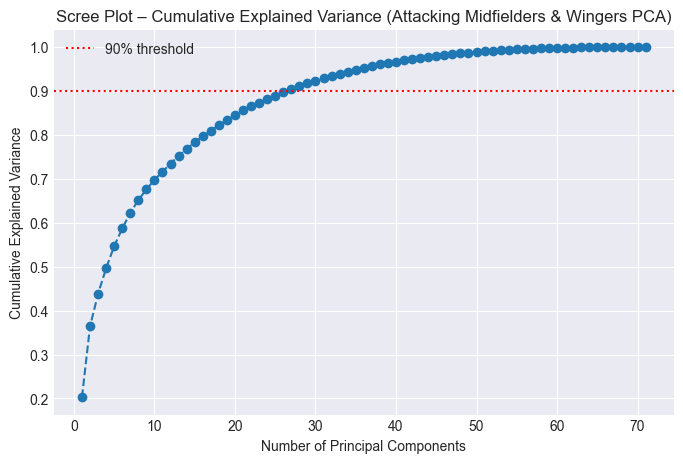

In [39]:
# === Scree plot ===
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var) + 1), cum_var, marker='o', linestyle='--', color='tab:blue')
plt.title("Scree Plot – Cumulative Explained Variance (Attacking Midfielders & Wingers PCA)")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.axhline(0.90, color='red', linestyle=':', label='90% threshold')
plt.grid(True)
plt.legend()
plt.show()


## 9. L2 Normalization for Tactical Radars


In [40]:
# Keep first 7 components for radars
n_pcs = 7
X_pca_reduced = X_pca[:, :n_pcs]

# L2-normalize for tactical radar (percentiles)
from sklearn.preprocessing import normalize
X_pca_normalized = normalize(X_pca_reduced, norm='l2')

attacking_mid_winger_pca_df = pd.DataFrame(
    X_pca_normalized,
    columns=[f"PC{i+1}" for i in range(n_pcs)],
    index=attacking_mid_winger_features_scaled_df.index
)

log_message(f"\n✓ Created L2-normalized PCA DataFrame: {attacking_mid_winger_pca_df.shape}")
print(attacking_mid_winger_pca_df.head())


[INFO] 
✓ Created L2-normalized PCA DataFrame: (474, 7)
                       PC1       PC2       PC3       PC4       PC5       PC6  \
player_season_id                                                               
12254_108         0.233683 -0.559440 -0.573803  0.230539  0.431789  0.088980   
13034_108        -0.033711 -0.046241  0.625924 -0.007340  0.001360 -0.764861   
30458_108         0.454958 -0.220861 -0.558240  0.031767  0.299012  0.580710   
25115_108         0.888686  0.212909  0.324809 -0.131436  0.184308  0.044756   
35785_108        -0.582660 -0.549757 -0.117957 -0.383852 -0.309064  0.290029   

                       PC7  
player_season_id            
12254_108         0.235926  
13034_108         0.140980  
30458_108         0.070431  
25115_108         0.078474  
35785_108        -0.131838  


## 10. Radar Chart Axes Definition


In [41]:
# Radar axes: PC → Label mapping (clockwise order)
RADAR_AXES = [
    {
        "pc": "PC1",
        "label": "Chance Creation",
        "tooltip": "How much a player drives shot creation via key passes and involvement in chance chains."
    },
    {
        "pc": "PC2",
        "label": "Ball Progression",
        "tooltip": "Involvement and reliability advancing play through passes and carries."
    },
    {
        "pc": "PC3",
        "label": "Width & Crossing",
        "tooltip": "Use of wide spaces and delivery quality into the box."
    },
    {
        "pc": "PC4",
        "label": "Defensive Work Rate",
        "tooltip": "Pressing intensity and ball-winning contribution from advanced areas."
    },
    {
        "pc": "PC5",
        "label": "Finishing Efficiency",
        "tooltip": "Shot quality and conversion efficiency in front of goal."
    },
    {
        "pc": "PC6",
        "label": "Risk & Verticality",
        "tooltip": "Direct, high-risk actions into pressure and dangerous zones."
    },
    {
        "pc": "PC7",
        "label": "Dribbling Threat",
        "tooltip": "1v1 take-on volume and carry distance to generate threat."
    }
]

log_message(f"✓ Defined {len(RADAR_AXES)} radar axes")
for axis in RADAR_AXES:
    print(f"  - {axis['pc']}: {axis['label']}")


[INFO] ✓ Defined 7 radar axes
  - PC1: Chance Creation
  - PC2: Ball Progression
  - PC3: Width & Crossing
  - PC4: Defensive Work Rate
  - PC5: Finishing Efficiency
  - PC6: Risk & Verticality
  - PC7: Dribbling Threat


## 11. Radar Plotting Helper Functions


In [53]:
def plot_radar(values, labels, title, player_name, season_name, mode='percentile', 
               fig_size=(8, 8), color='#1f77b4', alpha=0.25):
    """
    Plot a radar chart for a player (matching striker notebook style).
    
    Parameters:
    -----------
    values : list or array
        Values for each axis
    labels : list
        Axis labels
    title : str
        Chart title
    player_name : str
        Player name for subtitle
    season_name : str
        Season name for subtitle
    mode : str
        'percentile' or 'zscore'
    """
    num_vars = len(labels)
    
    # Compute angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    
    # Convert values to list if it's not already
    if not isinstance(values, list):
        values = values.tolist()
    else:
        values = values.copy()  # Make a copy to avoid modifying the original
    
    # Complete the circle
    values += values[:1]
    angles += angles[:1]
    
    # Create figure
    fig, ax = plt.subplots(figsize=fig_size, subplot_kw=dict(projection='polar'))
    
    # Plot data (matching striker notebook style)
    ax.plot(angles, values, 'o-', linewidth=2, label=player_name)
    ax.fill(angles, values, alpha=0.25)
    
    # Set labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=8)
    
    # Set y-axis limits based on mode
    if mode == 'percentile':
        ax.set_ylim(0, 100)
    else:  # zscore
        ax.set_ylim(-2.5, 2.5)
    
    # Title (matching striker notebook style)
    ax.set_title(f"{title}\\n{player_name} ({season_name})", 
                 size=12, fontweight='bold', pad=20)
    
    # Grid
    ax.grid(True)
    
    plt.tight_layout()
    return fig

log_message("✓ Radar plotting helper function defined")


[INFO] ✓ Radar plotting helper function defined


## 12. Generate Sample Radars


[INFO] 
[INFO] GENERATING SAMPLE RADARS FOR: Alessio da Cruz (2021/2022)
[INFO] ================================================================================


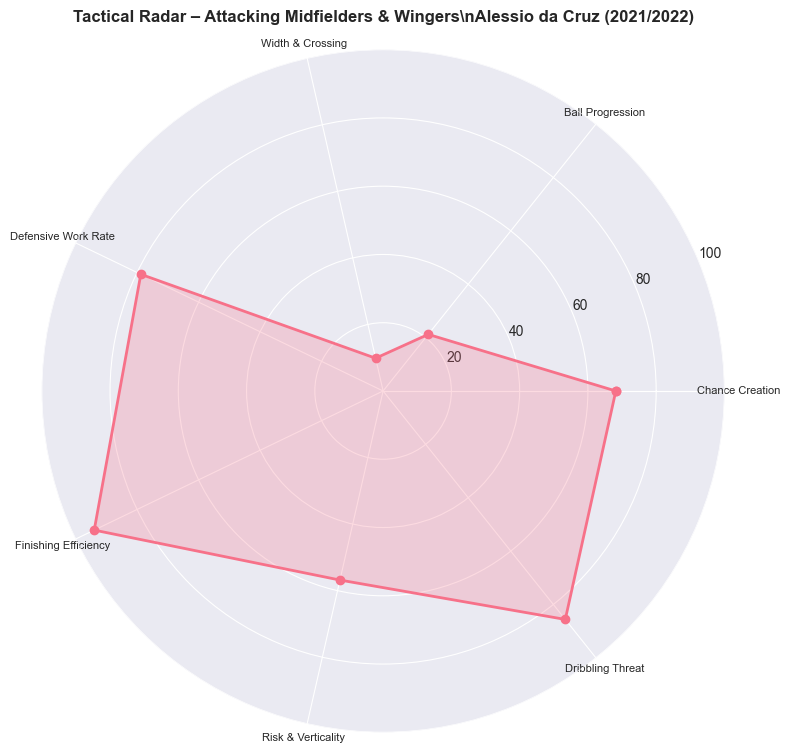

[INFO] ✓ Tactical radar generated (percentiles)
  - Chance Creation: 68.2th percentile
  - Ball Progression: 21.2th percentile
  - Width & Crossing: 9.8th percentile
  - Defensive Work Rate: 78.8th percentile
  - Finishing Efficiency: 93.9th percentile
  - Risk & Verticality: 56.8th percentile
  - Dribbling Threat: 85.6th percentile


In [54]:
# Select a sample player for demonstration
# Get player info by merging with combined_filtered
sample_player_season_id = attacking_mid_winger_pca_df.index[0]
player_info = combined_filtered[combined_filtered['player_season_id'] == sample_player_season_id].iloc[0]

player_name = player_info['player_name']
season_name = player_info['season_name']
season_id = player_info['season_id']

log_message(f"\n{'='*80}")
log_message(f"GENERATING SAMPLE RADARS FOR: {player_name} ({season_name})")
log_message(f"{'='*80}")

# Get player's PCA scores
player_pca_scores = attacking_mid_winger_pca_df.loc[sample_player_season_id].values

# Get season cohort for normalization
season_mask = combined_filtered['season_id'] == season_id
season_player_ids = combined_filtered[season_mask]['player_season_id'].values
season_cohort_pca = attacking_mid_winger_pca_df.loc[season_player_ids]

# ===== TACTICAL RADAR (Percentiles) =====
# Compute percentiles for each PC against season cohort
percentiles = []
for i, pc in enumerate([axis['pc'] for axis in RADAR_AXES]):
    pc_values = season_cohort_pca[pc].values
    player_value = player_pca_scores[i]
    percentile = (pc_values < player_value).sum() / len(pc_values) * 100
    percentiles.append(percentile)

# Plot tactical radar
labels_tactical = [axis['label'] for axis in RADAR_AXES]
fig_tactical = plot_radar(
    percentiles, 
    labels_tactical,
    "Tactical Radar – Attacking Midfielders & Wingers",
    player_name,
    season_name,
    mode='percentile',
    color='#2ecc71',
    alpha=0.3
)
plt.show()

log_message(f"✓ Tactical radar generated (percentiles)")
for i, (label, pct) in enumerate(zip(labels_tactical, percentiles)):
    print(f"  - {label}: {pct:.1f}th percentile")


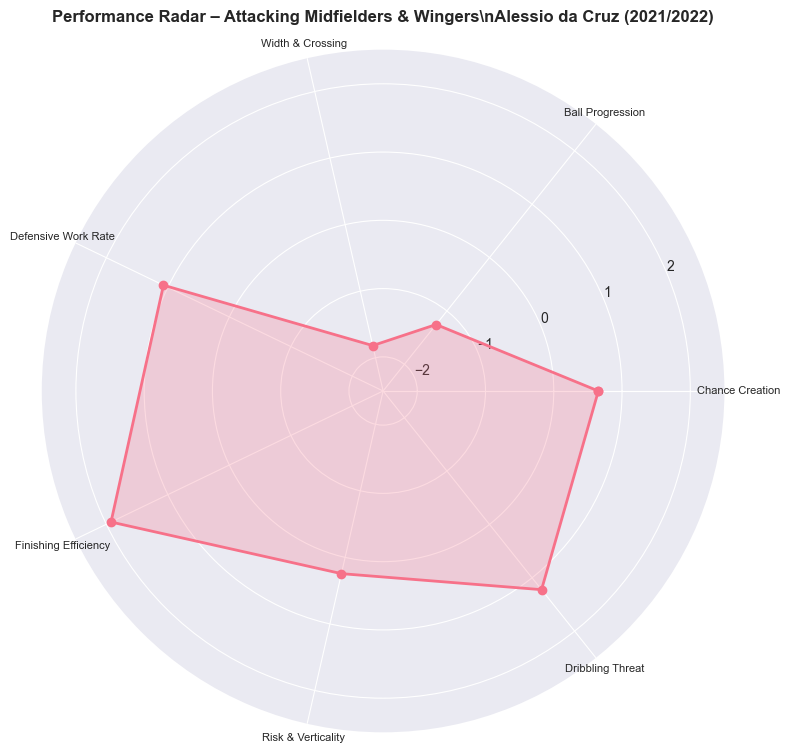

[INFO] 
✓ Performance radar generated (z-scores)
  - Chance Creation: z = 0.65
  - Ball Progression: z = -1.25
  - Width & Crossing: z = -1.82
  - Defensive Work Rate: z = 1.07
  - Finishing Efficiency: z = 1.92
  - Risk & Verticality: z = 0.24
  - Dribbling Threat: z = 1.22


In [55]:
# ===== PERFORMANCE RADAR (Z-scores) =====
# Get raw (non-normalized) PCA scores for z-score calculation
player_idx = attacking_mid_winger_pca_df.index.get_loc(sample_player_season_id)
player_raw_pca = X_pca_reduced[player_idx, :]

# Filter to season cohort using boolean indexing to avoid index issues
season_mask_pca = attacking_mid_winger_pca_df.index.isin(season_player_ids)
season_cohort_indices = np.where(season_mask_pca)[0]
season_raw_pca = X_pca_reduced[season_cohort_indices, :]

# Compute z-scores for each PC
zscores = []
for i in range(n_pcs):
    pc_values = season_raw_pca[:, i]
    player_value = player_raw_pca[i]
    mean_val = pc_values.mean()
    std_val = pc_values.std()
    
    if std_val > 0:
        zscore = (player_value - mean_val) / std_val
    else:
        zscore = 0
    
    zscores.append(zscore)

# Plot performance radar
labels_performance = [axis['label'] for axis in RADAR_AXES]
fig_performance = plot_radar(
    zscores,
    labels_performance,
    "Performance Radar – Attacking Midfielders & Wingers",
    player_name,
    season_name,
    mode='zscore',
    color='#e74c3c',
    alpha=0.3
)
plt.show()

log_message(f"\n✓ Performance radar generated (z-scores)")
for i, (label, z) in enumerate(zip(labels_performance, zscores)):
    print(f"  - {label}: z = {z:.2f}")


## 13. Generate Artifacts for App Integration


In [58]:
# Generate artifacts directory
import json

log_message(f"\n{'='*80}")
log_message("GENERATING APP ARTIFACTS")
log_message(f"{'='*80}")

# Create artifacts directory structure
ARTIFACT_BASE.mkdir(parents=True, exist_ok=True)

# 1. Generate ability_axes.json
axes_data = []
for axis in RADAR_AXES:
    axes_data.append({
        "key": axis['pc'],
        "label": axis['label'],
        "description": axis['tooltip']
    })

axes_path = ARTIFACT_BASE / "ability_axes.json"
with open(axes_path, 'w', encoding='utf-8') as f:
    json.dump(axes_data, f, indent=2)
log_message(f"✓ Saved ability_axes.json ({len(axes_data)} axes)")

# 2. Generate ability_scores_l2.parquet (L2-normalized PCA scores for percentiles)
ability_scores_l2_path = ARTIFACT_BASE / "ability_scores_l2.parquet"
attacking_mid_winger_pca_df.to_parquet(ability_scores_l2_path)
log_message(f"✓ Saved ability_scores_l2.parquet ({attacking_mid_winger_pca_df.shape[0]} players)")

# 3. Generate ability_scores_zscore.parquet (per-season z-score normalized)
# We need to compute z-scores per season for each PC
all_zscores = []

for season in SEASON_INFO:
    season_id = season['id']
    season_mask = combined_filtered['season_id'] == season_id
    season_player_ids = combined_filtered[season_mask]['player_season_id'].values
    
    if len(season_player_ids) == 0:
        continue
    
    # Filter to season cohort using boolean indexing
    season_mask_pca = attacking_mid_winger_pca_df.index.isin(season_player_ids)
    season_cohort_indices = np.where(season_mask_pca)[0]
    
    if len(season_cohort_indices) == 0:
        continue
    
    # Get raw PCA scores for this season
    season_raw_pca = X_pca_reduced[season_cohort_indices, :]
    
    # Get player IDs for this season
    season_player_ids_filtered = attacking_mid_winger_pca_df.index[season_mask_pca]
    
    # Compute z-scores for each PC within this season
    season_zscores = pd.DataFrame(
        index=season_player_ids_filtered,
        columns=[f"PC{i+1}" for i in range(n_pcs)]
    )
    
    for i in range(n_pcs):
        pc_values = season_raw_pca[:, i]
        mean_val = pc_values.mean()
        std_val = pc_values.std()
        
        if std_val > 0:
            zscores = (pc_values - mean_val) / std_val
        else:
            zscores = np.zeros(len(pc_values))
        
        season_zscores[f"PC{i+1}"] = zscores
    
    all_zscores.append(season_zscores)

# Combine all seasons
ability_scores_zscore = pd.concat(all_zscores)
ability_scores_zscore_path = ARTIFACT_BASE / "ability_scores_zscore.parquet"
ability_scores_zscore.to_parquet(ability_scores_zscore_path)
log_message(f"✓ Saved ability_scores_zscore.parquet ({ability_scores_zscore.shape[0]} players)")

# 4. Generate ability_percentiles.parquet (per-season percentiles from L2-normalized scores)
all_percentiles = []

for season in SEASON_INFO:
    season_id = season['id']
    season_mask = combined_filtered['season_id'] == season_id
    season_player_ids = combined_filtered[season_mask]['player_season_id'].values
    
    if len(season_player_ids) == 0:
        continue
    
    # Filter to players in this season
    season_pca = attacking_mid_winger_pca_df.loc[attacking_mid_winger_pca_df.index.isin(season_player_ids)]
    
    if len(season_pca) == 0:
        continue
    
    # Compute percentiles for each PC (vectorized approach)
    season_percentiles = pd.DataFrame(
        index=season_pca.index,
        columns=[f"PC{i+1}" for i in range(n_pcs)]
    )
    
    for pc in [f"PC{i+1}" for i in range(n_pcs)]:
        # Get all values for this PC
        pc_values = season_pca[pc].values
        # For each player, compute percentile by comparing against all values
        # Use vectorized rank calculation
        percentiles = (season_pca[pc].values[:, None] > pc_values).sum(axis=1) / len(pc_values) * 100
        season_percentiles[pc] = percentiles
    
    all_percentiles.append(season_percentiles)

# Combine all seasons
ability_percentiles = pd.concat(all_percentiles)
ability_percentiles_path = ARTIFACT_BASE / "ability_percentiles.parquet"
ability_percentiles.to_parquet(ability_percentiles_path)
log_message(f"✓ Saved ability_percentiles.parquet ({ability_percentiles.shape[0]} players)")

# 5. Generate league_reference.json (50th percentile for all axes)
league_reference = {axis['pc']: 50.0 for axis in RADAR_AXES}
league_reference_path = ARTIFACT_BASE / "league_reference.json"
with open(league_reference_path, 'w', encoding='utf-8') as f:
    json.dump(league_reference, f, indent=2)
log_message(f"✓ Saved league_reference.json")

# 6. Generate axis_ranges.json (min/max for L2-normalized scores)
axis_ranges = {}
for pc in [f"PC{i+1}" for i in range(n_pcs)]:
    axis_ranges[pc] = {
        "min": float(attacking_mid_winger_pca_df[pc].min()),
        "max": float(attacking_mid_winger_pca_df[pc].max())
    }

axis_ranges_path = ARTIFACT_BASE / "axis_ranges.json"
with open(axis_ranges_path, 'w', encoding='utf-8') as f:
    json.dump(axis_ranges, f, indent=2)
log_message(f"✓ Saved axis_ranges.json")

log_message(f"\n{'='*80}")
log_message(f"✓ ALL ARTIFACTS SAVED TO: {ARTIFACT_BASE.absolute()}")
log_message(f"{'='*80}")


[INFO] 
[INFO] GENERATING APP ARTIFACTS
[INFO] ================================================================================
[INFO] ✓ Saved ability_axes.json (7 axes)
[INFO] ✓ Saved ability_scores_l2.parquet (474 players)
[INFO] ✓ Saved ability_scores_zscore.parquet (474 players)
[INFO] ✓ Saved ability_percentiles.parquet (474 players)
[INFO] ✓ Saved league_reference.json
[INFO] ✓ Saved axis_ranges.json
[INFO] 
[INFO] ✓ ALL ARTIFACTS SAVED TO: c:\Users\carls\OneDrive\Dokumente\Uni\05 Semester\Marketing y Estrategia de Deportes\Projekt\Repo\ISAC2025\notebooks\..\data\processed\attacking_midfielders_wingers_artifacts
[INFO] ================================================================================


## ✅ App Integration Complete

The following artifacts have been generated and are ready for the Streamlit app:

### Generated Files:
- **`ability_axes.json`**: 7 tactical axes (PC1-PC7) with labels and tooltips
- **`ability_scores_l2.parquet`**: L2-normalized PCA scores for percentile calculations
- **`ability_scores_zscore.parquet`**: Per-season z-score normalized PCA scores
- **`ability_percentiles.parquet`**: Per-season percentiles (0-100) for each player
- **`league_reference.json`**: League average (50th percentile) for all axes
- **`axis_ranges.json`**: Min/max ranges for each axis

### Radar Axes (PC → Label Mapping):
1. **PC1 → Chance Creation**: Shot creation via key passes and chance involvement
2. **PC2 → Ball Progression**: Advancing play through passes and carries
3. **PC3 → Width & Crossing**: Wide play and delivery into the box
4. **PC4 → Defensive Work Rate**: Pressing and ball-winning from advanced areas
5. **PC5 → Finishing Efficiency**: Shot quality and conversion efficiency
6. **PC6 → Risk & Verticality**: Direct actions into pressure and dangerous zones
7. **PC7 → Dribbling Threat**: Take-on volume and carry distance

### Integration Status:
✅ **Service layer updated** (`core/profiles/service.py`):
   - Added `is_attacking_mid_winger()` method
   - Added `build_attacking_mid_winger_profile()` method
   - Integrated into `build_profile()` auto-detection

✅ **Player Database updated** (`pages/2_Player_Database.py`):
   - AM/W players now show tactical radars automatically
   - Caption explains 7 tactical dimensions
   - Info message updated to include AM/W cohort

### How to Use in App:
1. Run all cells in this notebook to generate artifacts
2. Start the Streamlit app: `streamlit run app.py`
3. Navigate to **Player Database**
4. Select any AM/W player (Right Wing, Left Wing, CAM, etc.)
5. Click **"📊 View Tactical Profile"**
6. Two radars will display:
   - **Tactical Radar**: Percentiles (0-100) relative to season cohort
   - **Performance Radar**: Z-scores (-2.5 to +2.5) relative to season cohort

### Position Cohort:
- Right Midfielder, Left Midfielder
- Right Wing, Left Wing
- Right Attacking Midfielder, Centre Attacking Midfielder, Left Attacking Midfielder
- **Minimum 500 minutes** per season
- **474 total player-seasons** across 4 Liga MX seasons (2021-2025)
